# Ethereum WRSI Backtesting Strategy

This notebook presents a backtesting strategy using Wilder's Relative Strength Index (WRSI) on Ethereum (ETH) price data. The goal is to explore and identify optimal buy and sell signal parameters based on the WRSI to maximize returns from trading strategies. Let's start by importing the necessary libraries and loading the data.


In [39]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
import time
from itertools import product

Now let's establish the ticker, the time frame for the backtest.

In [41]:
# initialise ticket, start and end of backtest
ticker = "ETH-USD"
start = "2022-01-01"
end = "2024-01-01"

We can use the `yfinance` library to fetch the data from Yahoo Finance and pandas to set up a DataFrame to store the data. 

In [42]:
# get ETH price data for backtest
ETH = yf.download(tickers=ticker, start=start,
                  end=end, progress=False)["Adj Close"]

df = pd.DataFrame()
df["PRICE"] = ETH
df.head()

/Users/rohanmahendraker/Desktop/Projects/finance/backtest-wrsi/venv/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,PRICE
Date,
2022-01-01,3769.697021
2022-01-02,3829.564941
2022-01-03,3761.380371
2022-01-04,3794.056641
2022-01-05,3550.386963


To generate log returns we can use the `numpy` library and the formula `np.log(df['Close'] / df['Close'].shift(1))`. We use log returns because they are additive and can be used to calculate the return of an asset over time.

In [43]:
# Generate Log returns
df["RETURNS"] = np.log(df["PRICE"] / df["PRICE"].shift(1))
df['RETURNS'].head()

Date
2022-01-01         NaN
2022-01-02    0.015757
2022-01-03   -0.017965
2022-01-04    0.008650
2022-01-05   -0.066379
Name: RETURNS, dtype: float64

Now we can define the WRSI indicator. The WRSI is a momentum oscillator that measures the speed and change of price movements. It is similar to the RSI, but it is based on the average gain and average loss over a specific period. The WRSI is calculated using the following function:

<Axes: >

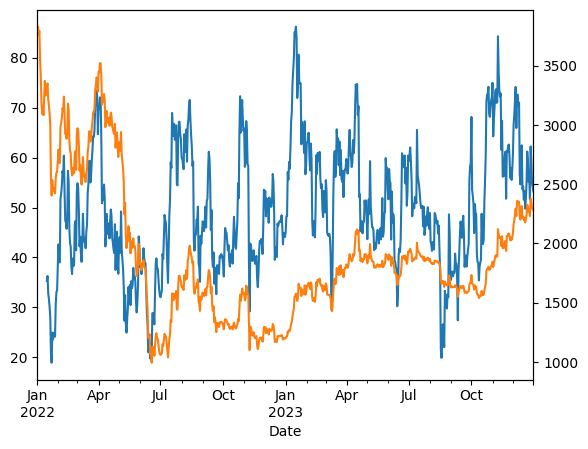

In [44]:
# Define WRSI function
def WRSI(series, n=14):
    """ function to calculate Wilder’s smoothing RSI 
    given a series and optional time window (n)"""

    # calculate the difference in the series
    delta = series.diff().fillna(0)

    # parse out the up and down closes
    upClose = pd.Series(np.where(delta > 0, delta, 0), index=delta.index)
    downClose = pd.Series(
        np.where(delta < 0, np.abs(delta), 0), index=delta.index)

    # Set the first avgUp and avgDown to be the rolling mean for the first window of size n.
    avgUp = pd.Series(upClose, index=delta.index)[
        1:].rolling(window=n, min_periods=n).mean()
    avgDown = pd.Series(downClose, index=delta.index)[
        1:].rolling(window=n, min_periods=n).mean()

    # Iterate through the series updating the values sequentially as per the formula.
    for i in range(n, len(delta.index)-1):
        avgUp.iloc[i] = (avgUp.iloc[i-1] * (n - 1) + upClose.iloc[i+1]) / n
        avgDown.iloc[i] = (avgDown.iloc[i-1] * (n - 1) +
                           downClose.iloc[i+1]) / n

    # determine the WRSI
    WRSI = 100 - (100 / (1 + (avgUp / avgDown)))

    # Return the series
    return WRSI

df["WRSI"] = WRSI(df["PRICE"])
df["WRSI"].plot()
df["PRICE"].plot(secondary_y=True)


Now that we have the WRSI, we can define the buy and sell signals. Note that we are setting arbitrary thresholds for the buy and sell signals. We will optimize these thresholds later. For the strategy itself we are assuming that we can both go long and short and that once we are in a position we will hold it until the signal changes.

<Axes: xlabel='Date'>

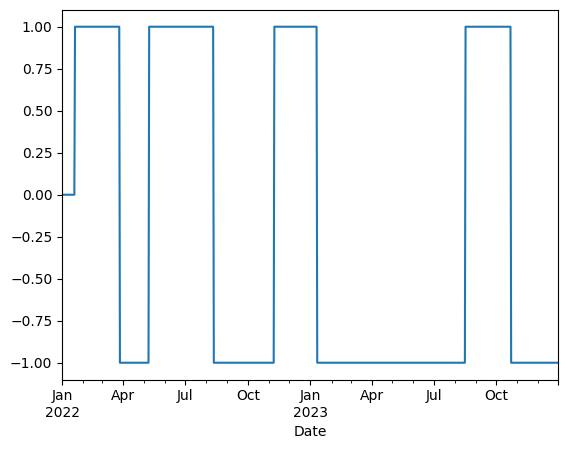

In [47]:
# Initialise buy and sell signals for WRSI
BUY = 30
SELL = 70

df["SIGNAL"] = np.where(df["WRSI"] <
                        BUY, 1, np.where(df["WRSI"] > SELL, -1, np.nan))

# Hold the position until you sell and then short
df["SIGNAL"] = df['SIGNAL'].ffill()


# Set initial position to 0 for neutral start
df["SIGNAL"] = df['SIGNAL'].fillna(0)
df["SIGNAL"].plot(ylim=[-1.1, 1.1])


Now to generate the strategy returns we can multiply the returns by the shifted buy and sell signals.

<Axes: xlabel='Date'>

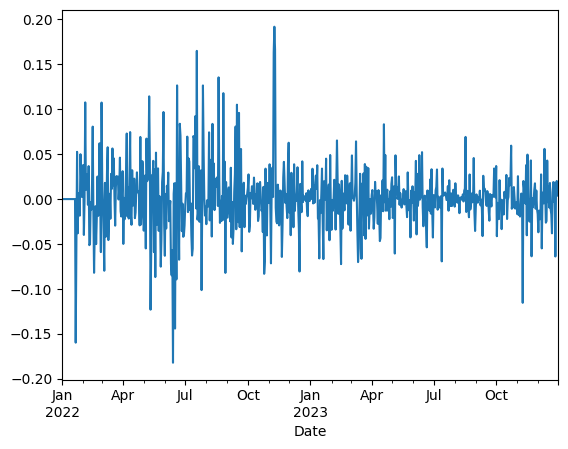

In [49]:
df["STRATEGY"] = df["RETURNS"] * df["SIGNAL"].shift(1)
df["STRATEGY"].plot()

To illustrate the strategy returns vs the buy and hold returns we can plot both on the same graph 0'ing them at the start of the backtest.

<Axes: title={'center': 'ETH WRSI Strategy vs ETH Hold'}, xlabel='Date', ylabel='Returns'>

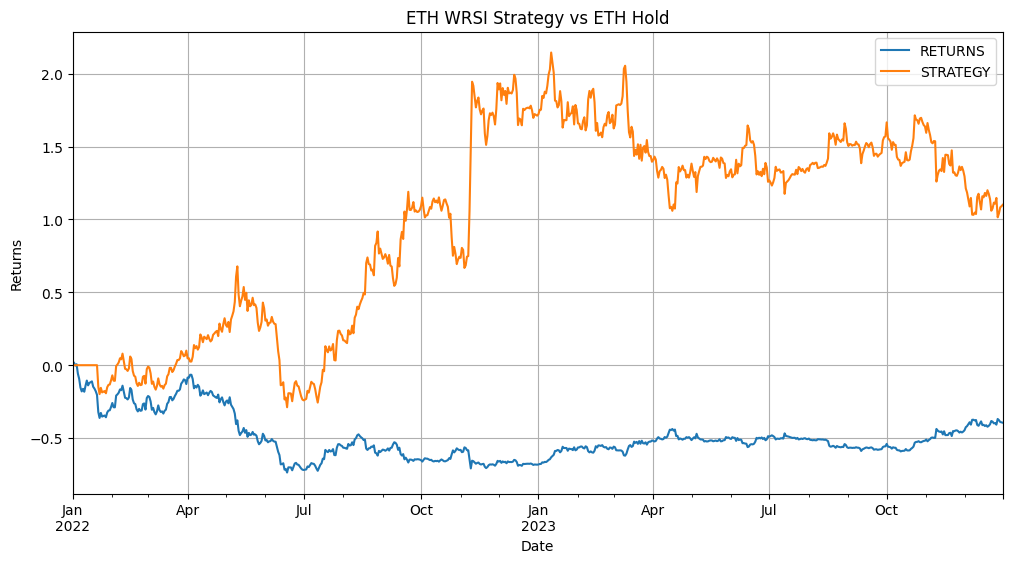

In [50]:
df[["RETURNS", "STRATEGY"]]\
    .cumsum()\
    .apply(np.exp)\
    .add(-1) \
    .plot(figsize=(12, 6), title="ETH WRSI Strategy vs ETH Hold",
          ylabel="Returns",
          grid=True,
          )

Wow we can see that the strategy returns are much higher than the buy and hold returns. This is a good sign that the strategy is working. But how do we know that the BUY, SELL and wilder's window are optimal? Maybe we got lucky? Well now we can iterate over different values for the BUY, SELL and wilder's window and see which combination gives us the highest returns so we can optimize the strategy.

In [35]:
# Iterate to find optimal parameters
rsi_buy = range(30, 31) # CHANGE THIS RANGE to 0, 31 but be aware of the time it will take to run
rsi_sell = range(70, 71) # CHANGE THIS RANGE to 70, 101 but be aware of the time it will take to run
n_window = range(7,8) # CHANGE THIS RANGE to 1, 16 but be aware of the time it will take to run

# Create results dataframe
results = []

# Initialise start time
start = time.time()

# Iterate through the set of buy, sell and n_window combinations
for RSI_BUY, RSI_SELL, N_WINDOW in product(rsi_buy, rsi_sell, n_window):
    # Create dataframe to hold results
    data = pd.DataFrame()

    # Extract adj close
    data["ADJ_CLOSE"] = ETH

    # Calculate WRSI given the function
    data["WRSI"] = WRSI(ETH, N_WINDOW)

    # Calculate the LONG_SHORT positions given the WRSI buy and sell signals.
    data["LONG_SHORT"] = np.where(
        data["WRSI"] < RSI_BUY, 1, np.where(data["WRSI"] > RSI_SELL, -1, np.nan)
    )

    # Hold position until you short
    data["LONG_SHORT"] = data["LONG_SHORT"].ffill()

    # Start neutral position at 0
    data["LONG_SHORT"] = data["LONG_SHORT"].fillna(0)

    # Calculate log returns
    data["LOG_RETURNS"] = np.log(data["ADJ_CLOSE"] / data["ADJ_CLOSE"].shift(1))

    # Calculate strategy returns given positions and log returns
    data["STRAT_RETURNS"] = data["LOG_RETURNS"] * data["LONG_SHORT"].shift(1)

    # Calcluate peformance
    performance = np.exp(data[["LOG_RETURNS", "STRAT_RETURNS"]].sum())

    # Append results to the results df
    results.append(
        {
            "RSI_BUY": RSI_BUY,
            "RSI_SELL": RSI_SELL,
            "N_WINDOW": N_WINDOW,
            "MARKET": performance["LOG_RETURNS"],
            "STRATEGY": performance["STRAT_RETURNS"],
            "OUTPERFORMANCE": performance["STRAT_RETURNS"] - performance["LOG_RETURNS"],
        }
    )

results = pd.DataFrame(results)

results

,RSI_BUY,RSI_SELL,N_WINDOW,MARKET,STRATEGY,OUTPERFORMANCE
0,30,70,7,0.605213,0.540492,-0.064721


Now we have the optimal parameters for the strategy! 
